In [12]:
%matplotlib inline
import numpy as np
from math import log
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10, 10)

In [13]:
A = np.matrix('0 0 0 0; 0.5 0 0 0; 0 0.5 0 0; 0 0 1 0')
a = np.matrix('0; 0.5; 0.5; 1')
v = 1/6
b = np.matrix([[v], [2*v], [2*v], [v]])

In [14]:
def f(u,t):
    return u+t**2+1
u0 = 0.5

In [15]:
def simple_solver(f, u0, t):
    u = np.array([u0]*len(t))
    for i,ui in enumerate(u[:-1]):
        tau = t[i+1] - t[i]
        w1 = f(ui,t[i])
        w2 = f(ui + tau*w1/2, t[i] + tau/2)
        w3 = f(ui + tau*w2/2, t[i] + tau/2)
        w4 = f(ui + tau*w3, t[i] + tau)
        u[i+1] = ui + tau * (w1 + 2*w2 +2*w3 + w4)/6
    return u,t
def effective_p(U2,U1,U0,r):
    return np.log((U2-U1)/(U1-U0))/np.log(r)

In [16]:
answers = [ simple_solver(f, u0, np.linspace(0, 1, 2**i+1)) for i in range(8)]

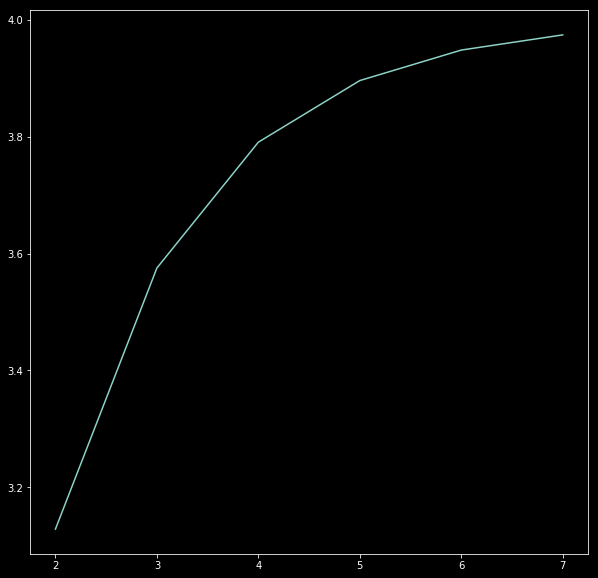

In [17]:
effective_p_in_1 = [effective_p(answers[i][0][-1], answers[i-1][0][-1], answers[i-2][0][-1], 1/2) for i in range(2, len(answers))]
plt.plot(range(2,len(answers)), effective_p_in_1)

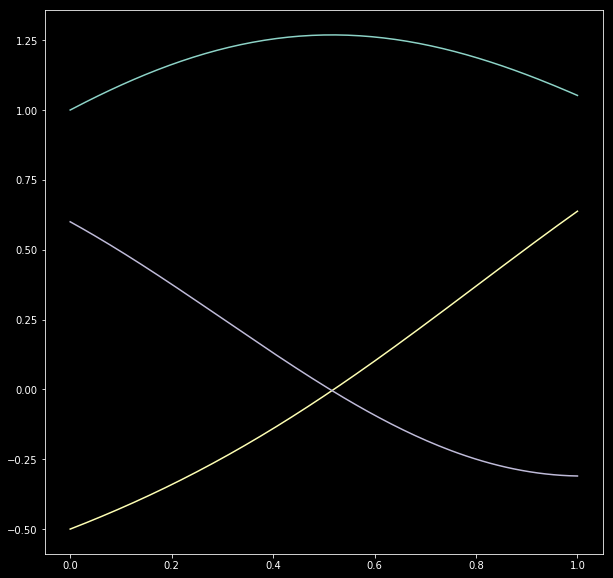

In [18]:
from numpy import sin, cos, pi
def f1(u, t):
    om = [sin(t), cos(t), sin(t+pi/4)]
    Omega = np.matrix([[0, -om[2], om[1]], [om[2], 0, -om[0]],[-om[1], om[0], 0]])
    return Omega*u
answers1 = [ simple_solver(f1, np.matrix('1; -0.5; 0.6'), np.linspace(0, 1, 2**i + 1)) for i in range(8) ]
plt.figure()
plt.plot(answers1[-1][1], [t.item(0,0)for t in answers1[-1][0]])
plt.plot(answers1[-1][1], [t.item(1,0)for t in answers1[-1][0]])
plt.plot(answers1[-1][1], [t.item(2,0)for t in answers1[-1][0]])

Для реализации на компьютере в системе MATLAB удобнее записать в векторной форме

$	\begin{split}
		\mathbf{u}_{n+1} = \mathbf{u}_n + \tau_n \boldsymbol{\omega} \mathbf{b}^T,
	\qquad
		\tau_n = t_{n+1} - t_n; \\
		\boldsymbol{\omega}_k = \mathbf{f} \left( \mathbf{u}_n + \tau_n \boldsymbol{\omega} \boldsymbol{\alpha}^T_k, t_n + \tau_n a_k \right),
	\qquad
		1 \le k \le s,
	\end{split}$

где $\boldsymbol{\omega}_k$ - $k$-тая строка матрицы промежуточных результатов $\boldsymbol{\omega}$, первоначально полагаемой нулевой, $\mathbf{b}$ - вектор-строка коэффициентов $b$ и $\boldsymbol{\alpha}_k$ - $k$-тая строка матрицы Бутчера. Верхний индекс $T$ означает транспонирование.

In [19]:
butcher = [ np.array([0, 0, 0, 0, 0, 0, 0]), np.array([4/7, 0, 0, 0, 0, 0, 0]), np.array([115/112, -5/16, 0, 0, 0, 0, 0]), np.array([589/630, 5/18, -16/45, 0, 0, 0, 0]),
np.array([229/1200-29/6000*5**0.5, 119/240-187/1200*5**0.5, -14/75+34/375*5**0.5, -3/100*5**0.5, 0, 0, 0]),
np.array([71/2400-587/12000*5**0.5, 187/480-391/2400*5**0.5, -38/75+26/375*5**0.5, 27/80-3/400*5**0.5, (1+5**0.5)/4, 0, 0]),
np.array([-49/480+43/160*5**0.5, -425/96+51/32*5**0.5, 52/15-4/5*5**0.5, -27/16+3/16*5**0.5, 5/4-3/4*5**0.5, 5/2-0.5*5**0.5, 0]) ]
a = np.array([0, 4/7, 5/7, 6/7, (5-5**0.5)/10, (5+5**0.5)/10, 1]);
b = np.array([1/12, 0, 0, 0, 5/12, 5/12, 1/12]);
u0 = np.array([1, -0.5, 0.6])

In [20]:
def mult(vect,list_):
    res = np.matrix(np.zeros(vect[0].shape))
    for v,l in zip(vect,list_):
        res+= v*l
    return res
def universal_runge_kutta(f ,u0, t, butcher, a, b):
    u = np.array([u0] * len(t))
    w = [np.matrix(np.zeros(u0.shape))] * len(butcher)
    for i,ui in enumerate(u[:-1]):
        tau = t[i+1] - t[i]
        for j,wj in enumerate(w):
            w[j] = f(ui + tau * mult(w, butcher[j]),t[i] + tau * a[j])
        u[i+1] = ui + tau * mult(w,b)
    return u,t

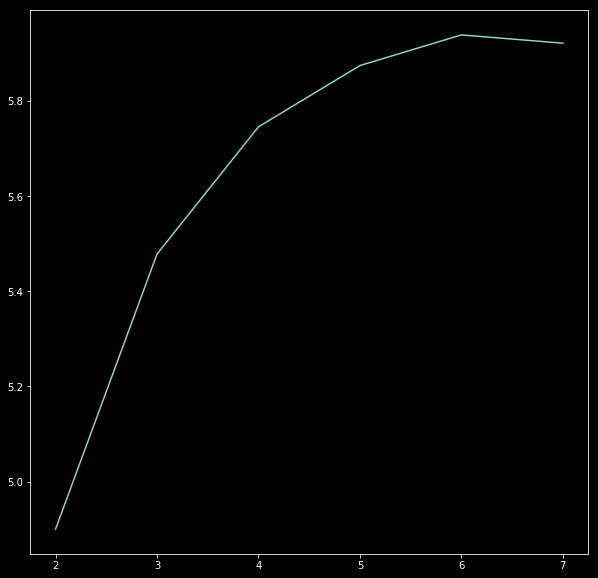

In [21]:
answers2 = [ universal_runge_kutta(f, np.matrix([[0.5]]),np.linspace(0, 1, 2**i + 1), butcher, a, b) for i in range(8)]
effective_p_in_1_2 = [effective_p(answers2[i][0][-1], answers2[i-1][0][-1], answers2[i-2][0][-1], 1/2) for i in range(2, len(answers2))]
plt.plot(range(2,len(answers2)), [t[0][0] for t in effective_p_in_1_2])

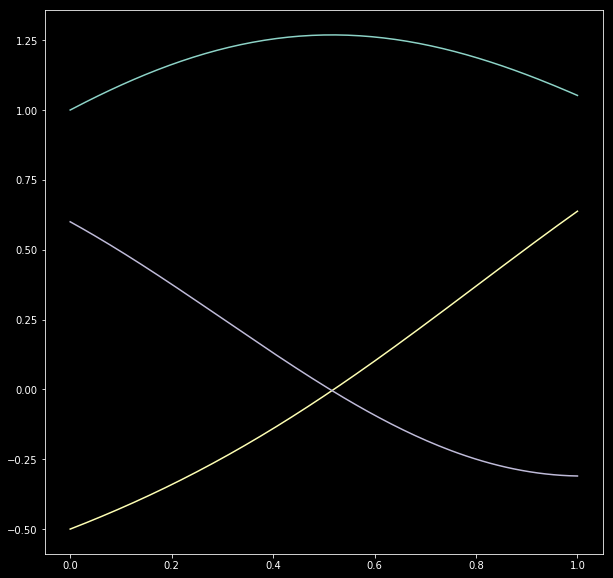

In [23]:
answers3 = [ universal_runge_kutta(f1, np.matrix('1; -0.5; 0.6'), np.linspace(0, 1, 2**i + 1), butcher, a, b) for i in range(15) ]
plt.figure()
plt.plot(answers1[-1][1], [t.item(0,0)for t in answers1[-1][0]])
plt.plot(answers1[-1][1], [t.item(1,0)for t in answers1[-1][0]])
plt.plot(answers1[-1][1], [t.item(2,0)for t in answers1[-1][0]])